# Hamiltonian simulation with Gray code encoding - statevector simulator

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()


import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *

## Time evolution of the deuteron system

Consider the $N=4$ deuteron system. We have two Hamiltonians obtained from the Gray code and one-hot encodings. Starting from an arbitrary quantum state, we can compute the state after the system evolves for time $t$ analytically as
$$
 |\psi(t)\rangle = e^{-iHt} |\psi(0)\rangle
$$

Let's suppose that $|\psi(0)\rangle$ is the uniform superposition of basis states for each system. For the Gray code, we have
$$
|\psi(0)\rangle = \frac{1}{2} \left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right)
$$
while for one-hot, we are concerned with a subset of the basis states of a 4-qubit system:
$$
|\psi(0)\rangle = \frac{1}{2} \left( |0001\rangle + |0010\rangle + |0100\rangle + |1000\rangle \right)
$$

If we run Hamiltonian simulation on both systems (with their respective Hamiltonians and starting states), we should see the same trajectories of the basis states (i.e. the probabilities of the states occuring at a given time should be the same across both versions for the analogous states).

First, let's make sure that happens.

In [2]:
# Perform unitary evolution 
def unitary_evolution(ham, t):
    return expm(-1j * ham * t)

# Basis states for the two systems
# This is the ordering of the labels in the paper; this is "normal" qubit ordering
# In Qiskit, when we grab the relevant things from the basis vectors, we need to grab the 
# *reverse*, so for OH we will be taking elements 1, 2, 4, 8, in that order, and for Qiskit
# 0, 1, 3, 2
states_gc = ['00', '10', '11', '01']
states_oh = ['1000', '0100', '0010', '0001']

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Some simulation parameters; for better 'resolution', increase the number of timesteps 
timesteps = 1000
start_time = 0
end_time = 2
time_range = np.linspace(start_time, end_time, timesteps)

First let's see what happens with the Gray code version.

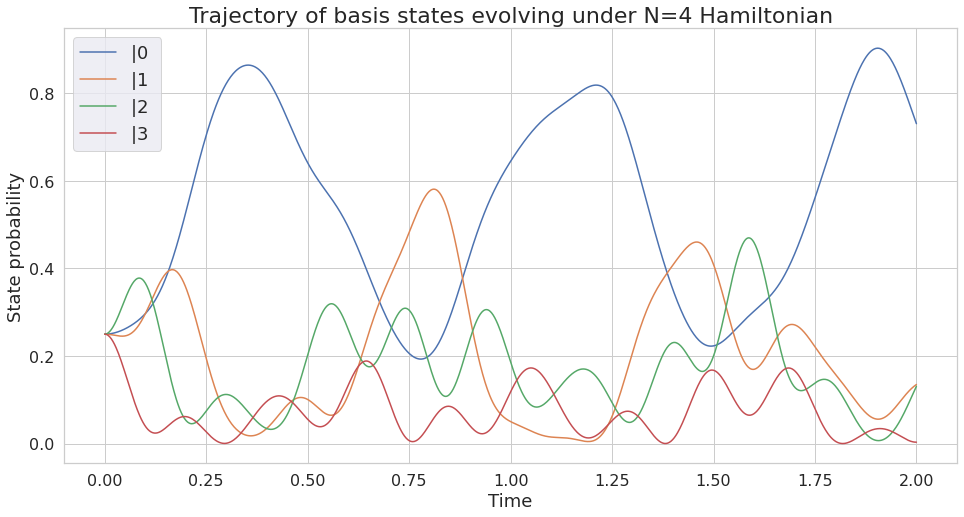

In [3]:
trajectories_gc = np.zeros((timesteps, 4))

H = DenseEncodingHamiltonian(N_states=4)
gc_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H.pauli_coeffs.items()])

uniform_gc = 0.5 * np.array([[1], [1], [1], [1]])

for time_idx, time in enumerate(list(time_range)):
    wavefunction = unitary_evolution(gc_ham_rep, t=time) @ uniform_gc
    true_probabilities = (wavefunction * np.conj(wavefunction)).flatten()
    # Need to pull probabilities in the correct ordering that we have basis states in - 00, 10, 11, 01
    trajectories_gc[time_idx, 0] = true_probabilities[0].real
    trajectories_gc[time_idx, 1] = true_probabilities[1].real
    trajectories_gc[time_idx, 2] = true_probabilities[3].real
    trajectories_gc[time_idx, 3] = true_probabilities[2].real
    
with sns.axes_style("whitegrid"):
    for state_idx, state in enumerate(states_gc):
        plt.plot(time_range, trajectories_gc[:, state_idx], label=f"|{state_idx} ")
plt.xlabel("Time", fontsize=18)
plt.ylabel("State probability", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Trajectory of basis states evolving under N=4 Hamiltonian", fontsize=22)
plt.legend(fontsize=18);
#plt.savefig("paper-figures/ham_sim_trajectory.pdf")

In [4]:
# Check that all probabilities sum to 1 at each time step
np.all(np.isclose(np.sum(trajectories_gc, axis=1),1.))

True

Now let's do the same for one-hot. This one takes a little longer since the system is larger.

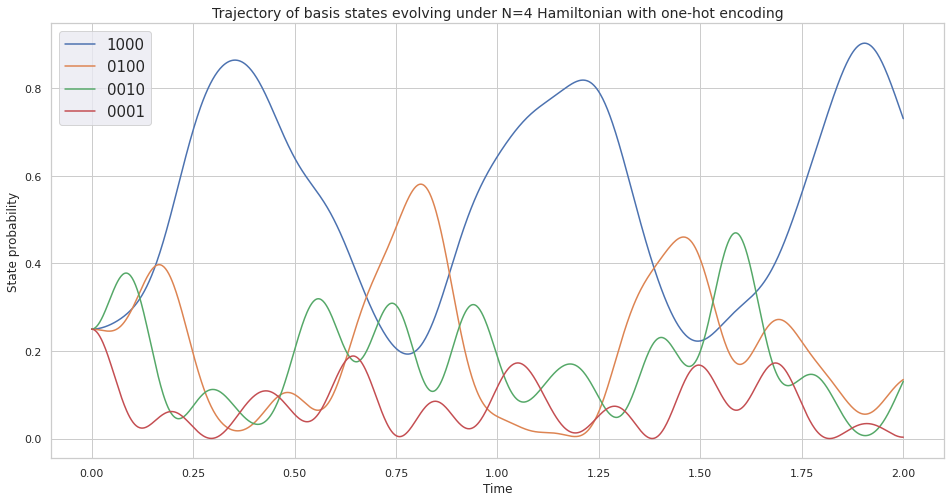

In [5]:
trajectories_oh = np.zeros((timesteps, 4))

oh = SparseEncodingHamiltonian(N_states=4)
oh_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in oh.pauli_coeffs.items()])
uniform_oh = 0.5 * np.array([[0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0]]).reshape((16, 1))

for time_idx, time in enumerate(list(time_range)):
    wavefunction = unitary_evolution(oh_ham_rep, t=time) @ uniform_oh
    true_probabilities = (wavefunction * np.conj(wavefunction)).flatten()
    trajectories_oh[time_idx, 0] = true_probabilities[1].real
    trajectories_oh[time_idx, 1] = true_probabilities[2].real
    trajectories_oh[time_idx, 2] = true_probabilities[4].real
    trajectories_oh[time_idx, 3] = true_probabilities[8].real
    
with sns.axes_style("whitegrid"):
    for state_idx, state in enumerate(states_oh):
        plt.plot(time_range, trajectories_oh[:, state_idx], label=state)
plt.xlabel("Time")
plt.ylabel("State probability")
plt.title("Trajectory of basis states evolving under N=4 Hamiltonian with one-hot encoding", fontsize=14)
plt.legend(fontsize=15);

In [6]:
# Check that all probabilities sum to 1 at each time step
np.all(np.isclose(np.sum(trajectories_oh, axis=1),1.))

True

Great - we see that the system evolves in exactly the same way, under the appropriate Hamiltonians.

## Simulation

Now let's take a look at what happens for one particular evolution time, but doing digital quantum simulation. Now we will have to Trotterize the Hamiltonian, which introduces error.

In [7]:
# Arbitrary simulation time
T = 1

# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 100

backend = Aer.get_backend('statevector_simulator')

In [8]:
H_gc = DenseEncodingHamiltonian(N_states=4)

# Get the matrix in "qiskit order"
gc_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H_gc.pauli_coeffs.items()])
uniform_superposition_gc = 0.5 * np.array([[1], [1], [1], [1]])

wavefunction = unitary_evolution(gc_ham_rep, t=T) @ uniform_superposition_gc
true_probabilities = (wavefunction * np.conj(wavefunction)).flatten().real

true_results_gc = {'00' : true_probabilities[0],
                   '10' : true_probabilities[1],
                   '11' : true_probabilities[3],
                   '01' : true_probabilities[2]
                  }

In [9]:
exact_wavefunction_gc = unitary_evolution(gc_ham_rep, t=T) @ uniform_gc

In [10]:
exact_wavefunction_gc * np.conj(exact_wavefunction_gc)

array([[0.64489016+0.j],
       [0.0502703 +0.j],
       [0.11822167+0.j],
       [0.18661787+0.j]])

In [11]:
true_results_gc

{'00': 0.644890158887242,
 '10': 0.050270303872851696,
 '11': 0.18661786653005275,
 '01': 0.11822167070985606}

This code loops over the different numbers of Trotter steps and performs the evolution by running the circuit using the statevector simulator.

In [12]:
weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

results_dict_gc = {x : np.zeros(max_trotter_steps) for x in states_gc}

trace_dists_gc = np.zeros(max_trotter_steps)

# Hang on to the gate counts of the decomposed circuits
gate_counts_gc = np.zeros((max_trotter_steps, 3))

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps + 1)):
    # Prepare and run the evolution circuit
    q = QuantumRegister(H_gc.N_qubits)
    circuit = QuantumCircuit(q)
    
    circuit.h(q)
    
    circuit += my_pauli.evolve(
        None, evo_time=T, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
    
    # Get the gate counts
    gate_counts = circuit.decompose().count_ops()
    
    if 'u3' not in gate_counts.keys():
        gate_counts['u3'] = 0
    
    gate_counts_gc[n_trotter_steps - 1, 0] = gate_counts['u2'] + gate_counts['u3']
    gate_counts_gc[n_trotter_steps - 1, 1] = gate_counts['cx']
    gate_counts_gc[n_trotter_steps - 1, 2] = circuit.decompose().depth()
    
    # Get and process results
    job = execute(circuit, backend)
    statevector = job.result().get_statevector(circuit)
    results = job.result().get_counts(circuit)
    
    if n_trotter_steps == max_trotter_steps:
        print(statevector)
        
    trace_dists_gc[n_trotter_steps-1] = qt.tracedist(qt.Qobj(exact_wavefunction_gc), qt.Qobj(statevector))
    
    for state in results_dict_gc.keys():
        # Need to reverse the state we put the counts in because our labels are
        # normally ordered, and Qiskit gives them to us backwards
        results_dict_gc[state[::-1]][n_trotter_steps-1] = results[state]

100%|██████████| 100/100 [00:21<00:00,  4.57it/s]

[-0.59681694-0.54907562j -0.18006177+0.07798313j -0.29623272+0.19090765j
 -0.15747673+0.39347607j]


In [13]:
exact_wavefunction_gc

array([[-0.5742199 +0.56139261j],
       [ 0.09733696+0.20197975j],
       [ 0.17938808+0.29332846j],
       [ 0.39439354+0.17627138j]])

In [14]:
print(f"True state probabilities:")
for state in states_gc:
    print(f"{state}: {true_results_gc[state].real}")
print()
print(f"State probabilities at {max_trotter_steps} Trotter steps:")
for state in states_gc:
    print(f"{state}: {results_dict_gc[state][-1]}")

True state probabilities:
00: 0.644890158887242
10: 0.050270303872851696
11: 0.18661786653005275
01: 0.11822167070985606

State probabilities at 100 Trotter steps:
00: 0.657674500568077
10: 0.038503609254807
11: 0.179622336774216
01: 0.124199553402878


Text(0.5, 1.0, '4 states, 2 qubits (Gray code); evolution time T = 1, Trotter')

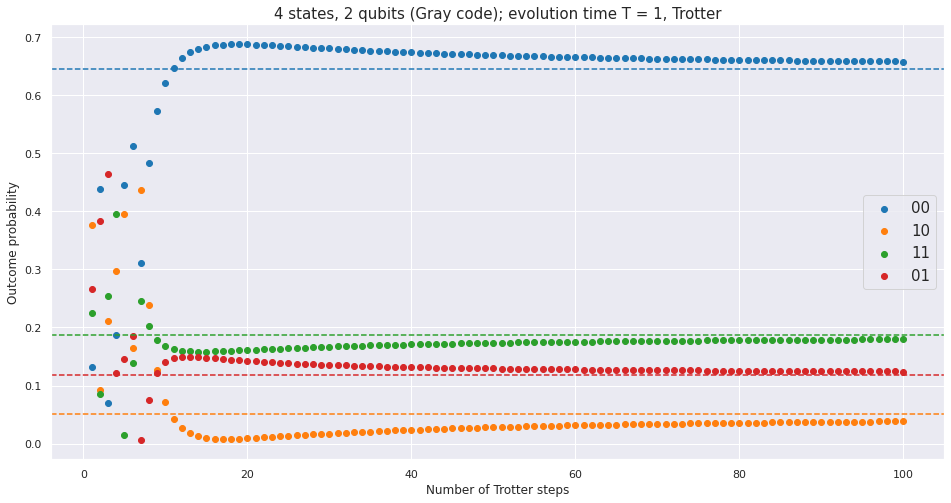

In [15]:
colour_idx = 0

for state in states_gc:
    plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_gc[state], label=state, color=colours[colour_idx])
    plt.axhline(y=true_results_gc[state], color=colours[colour_idx], linestyle='dashed')
    colour_idx += 1
plt.xlabel("Number of Trotter steps")
plt.ylabel("Outcome probability")
plt.legend(fontsize=15)
plt.title(f"4 states, 2 qubits (Gray code); evolution time T = {T}, Trotter", fontsize=15)
#plt.savefig("gc-trotter-probs.pdf")

Text(0.5, 1.0, '4 states, 2 qubits (Gray code); evolution time T = 1, Trotter')

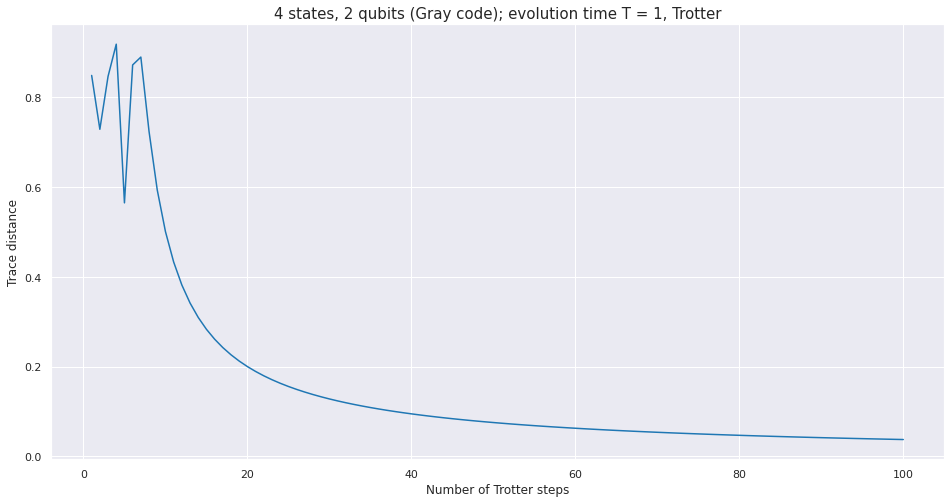

In [16]:
plt.plot(range(min_trotter_steps, max_trotter_steps+1), trace_dists_gc, color='tab:blue')
plt.xlabel("Number of Trotter steps")
plt.ylabel("Trace distance")
plt.title(f"4 states, 2 qubits (Gray code); evolution time T = {T}, Trotter", fontsize=15)
#plt.savefig("gc-trotter-probs.pdf")

Now we'll do the same thing for one-hot. We'll prepare the uniform superposition here by running the variational ansatz with the set of parameters that will produce it.

In [17]:
exact_wavefunction_oh = unitary_evolution(oh_ham_rep, t=T) @ uniform_oh

true_probabilities = (exact_wavefunction_oh * np.conj(exact_wavefunction_oh)).flatten()

true_results_oh = {'1000' : true_probabilities[1],
                   '0100' : true_probabilities[2],
                   '0010' : true_probabilities[4],
                   '0001' : true_probabilities[8]}

In [18]:
H_oh = SparseEncodingHamiltonian(N_states=4, qiskit_order=True)
weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_oh.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

results_dict_oh = {x : np.zeros(max_trotter_steps) for x in states_oh}

trace_dists_oh = np.zeros(max_trotter_steps)

# To prepare the uniform superposition, run the sparse variational ansatz with the following parameters
θ_1 = 2 * np.pi / 3
θ_2 = 2 * np.arccos(1/np.sqrt(3)) 
θ_3 = 2 * np.arccos(1/(np.sqrt(3) * np.sin(θ_2 / 2)))
params = [θ_1, θ_2, θ_3]

# Hang on to the gate counts of the decomposed circuits
gate_counts_oh = np.zeros((max_trotter_steps, 3))

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
    # Construct uniform superposition over spherical coordinates
    q = QuantumRegister(H_oh.N_qubits)
    
    circuit = QuantumCircuit(q)
    circuit.x(q[0])
    circuit.ry(θ_1, q[1])
    circuit.cx(q[1], q[0])
    circuit.cry(θ_2, q[1], q[2])
    circuit.cx(q[2], q[1])
    circuit.cry(θ_3, q[2], q[3])
    circuit.cx(q[3], q[2])
    
    circuit += my_pauli.evolve(
        None, evo_time=T, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
    
    gate_counts = circuit.decompose().count_ops()
    
    if 'u3' not in gate_counts.keys():
        gate_counts['u3'] = 0
    
    gate_counts_oh[n_trotter_steps - 1, 0] = gate_counts['u3']
    gate_counts_oh[n_trotter_steps - 1, 1] = gate_counts['cx']
    gate_counts_oh[n_trotter_steps - 1, 2] = circuit.decompose().depth()
    
    job = execute(circuit, backend)
    statevector = job.result().get_statevector(circuit)
    results = job.result().get_counts(circuit)
    
    if n_trotter_steps == max_trotter_steps - 1:
        print(statevector)
        
    #fidelities_oh[n_trotter_steps-1] = qt.fidelity(qt.Qobj(exact_wavefunction_oh), qt.Qobj(statevector))
    trace_dists_oh[n_trotter_steps-1] = qt.tracedist(qt.Qobj(exact_wavefunction_oh), qt.Qobj(statevector))  
    
    for state in results_dict_oh.keys():
        results_dict_oh[state[::-1]][n_trotter_steps-1] = results[state]

 99%|█████████▉| 99/100 [00:49<00:00,  1.03it/s]

[-2.73179709e-15-7.16360888e-15j -5.34975226e-01-6.16694009e-01j
 -1.90357034e-01+6.63789081e-02j -1.19441648e-15-5.76172360e-16j
 -1.95684227e-01+3.71513616e-01j -1.98108917e-15-2.51287574e-16j
 -5.24999684e-16+6.66989563e-16j  4.08198019e-03-1.00316663e-04j
 -3.07380728e-01+1.46571121e-01j  2.02537844e-15-6.86492886e-16j
  1.35105582e-15-6.72785775e-18j -7.35292503e-03+1.67299464e-02j
  2.80464270e-16+5.23119467e-17j  3.91090460e-04+1.34726231e-02j
 -5.85088439e-03-9.11781395e-04j -6.30718463e-16+1.45861894e-16j]


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


In [19]:
print(f"True state probabilities:")
for state in states_oh:
    print(f"{state}: {true_results_oh[state].real}")
print()
print(f"State probabilities at {max_trotter_steps} Trotter steps:")
for state in states_oh:
    print(f"{state}: {results_dict_oh[state][-1]}")

True state probabilities:
1000: 0.6448901588872414
0100: 0.05027030387285137
0010: 0.18661786653005197
0001: 0.11822167070985556

State probabilities at 100 Trotter steps:
1000: 0.666283031572762
0100: 0.040743775574844
0010: 0.176403000854422
0001: 0.11601385728056


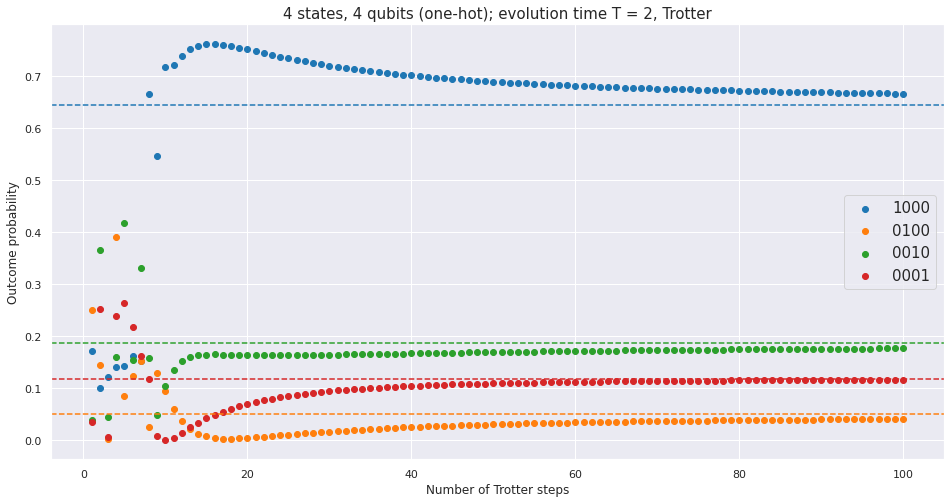

In [20]:
colour_idx = 0

for state in states_oh:
    plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_oh[state], label=state, color=colours[colour_idx])
    plt.axhline(y=true_results_oh[state], color=colours[colour_idx], linestyle='dashed')
    colour_idx += 1
    
plt.xlabel("Number of Trotter steps")
plt.ylabel("Outcome probability")
plt.legend(fontsize=15)
plt.title("4 states, 4 qubits (one-hot); evolution time T = 2, Trotter", fontsize=15);
#plt.savefig("oh-trotter-probs.pdf")

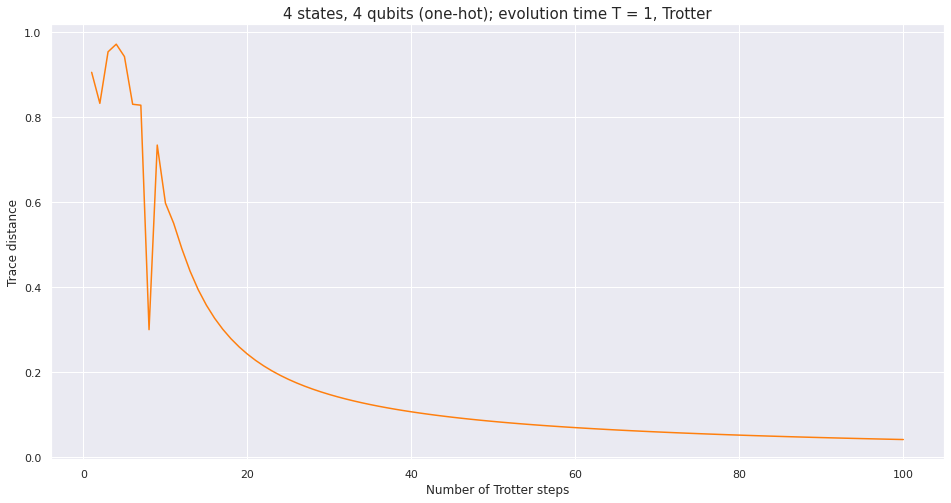

In [21]:
plt.plot(range(min_trotter_steps, max_trotter_steps+1), trace_dists_oh, color='tab:orange')
plt.xlabel("Number of Trotter steps")
plt.ylabel("Trace distance")
plt.title(f"4 states, 4 qubits (one-hot); evolution time T = {T}, Trotter", fontsize=15);
#plt.savefig("gc-trotter-probs.pdf")

Let's plot it all together...

Text(0.5, 1.0, 'N=4 encoding comparison for Hamiltonian evolution time t = 1')

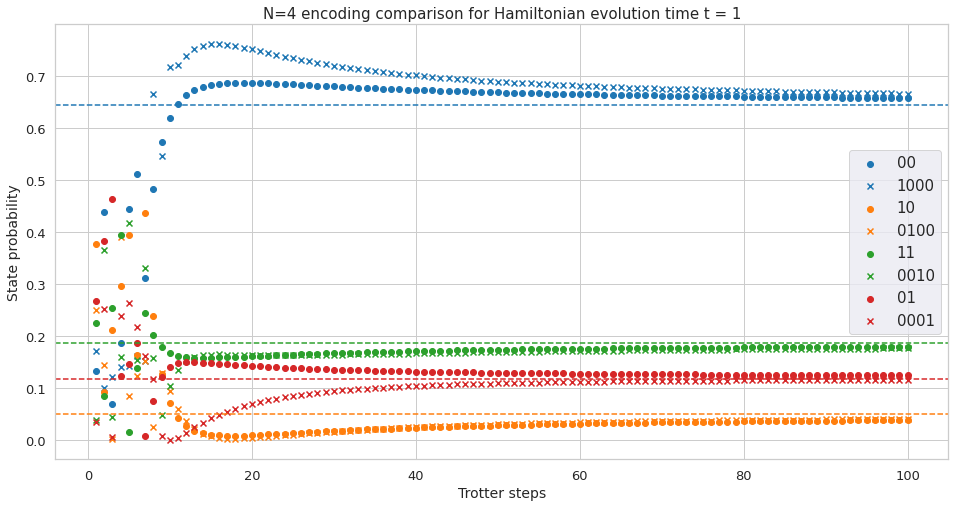

In [22]:
colour_idx = 0

with sns.axes_style("whitegrid"):
    for state_gc, state_oh in zip(states_gc, states_oh):
        plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_gc[state_gc], label=state_gc, color=colours[colour_idx])
        plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_oh[state_oh], label=state_oh, color=colours[colour_idx], marker='x')
        plt.axhline(y=true_results_oh[state_oh], color=colours[colour_idx], linestyle='dashed')
        colour_idx += 1
    
plt.xlabel("Trotter steps", fontsize=14)
plt.ylabel("State probability", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.title(f"N=4 encoding comparison for Hamiltonian evolution time t = {T}", fontsize=15)
#plt.savefig("paper-figures/trotter-probs-comparison.pdf")

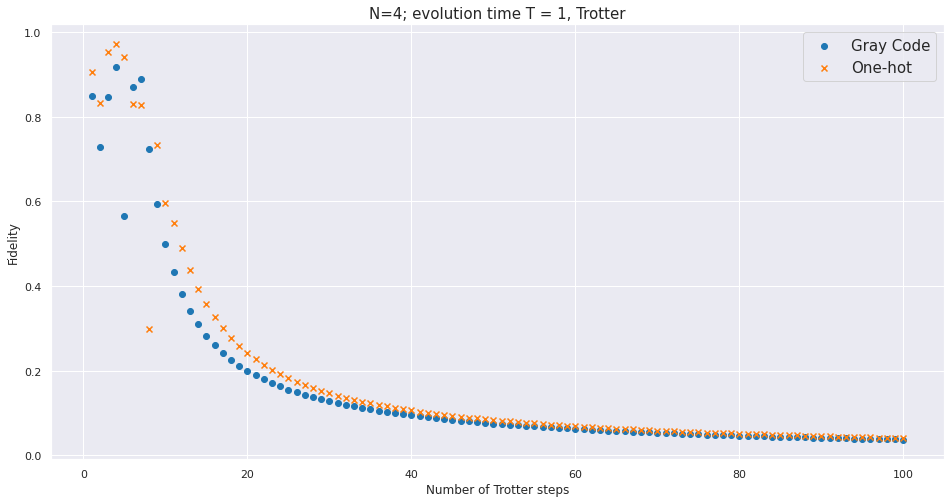

In [23]:
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), trace_dists_gc, color='tab:blue', label = "Gray Code")
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), trace_dists_oh, color='tab:orange', marker='x', label = "One-hot")
plt.xlabel("Number of Trotter steps")
plt.ylabel("Fidelity")
plt.legend(fontsize=15)
plt.title(f"N=4; evolution time T = {T}, Trotter", fontsize=15);
#plt.savefig("gc-trotter-probs.pdf")

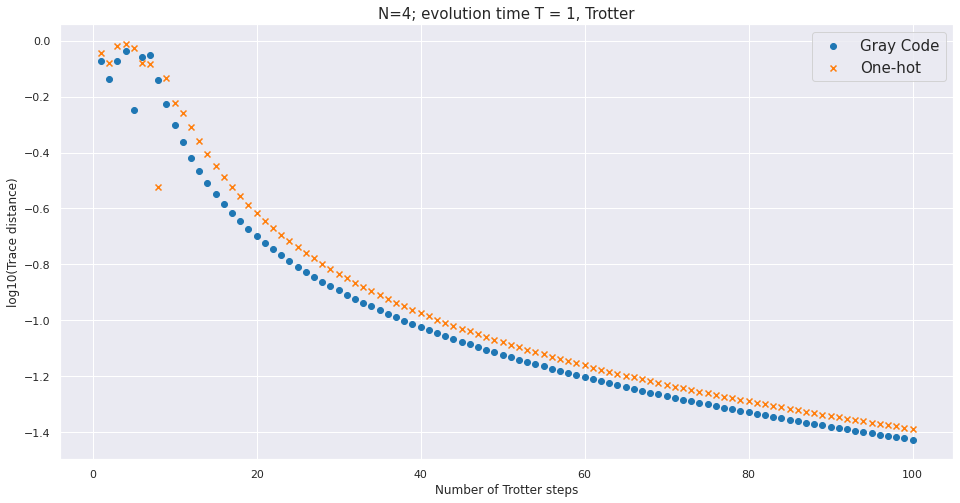

In [24]:
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), np.log10(trace_dists_gc), color='tab:blue', label = "Gray Code")
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), np.log10(trace_dists_oh), color='tab:orange', marker='x', label = "One-hot")
plt.xlabel("Number of Trotter steps")
plt.ylabel("log10(Trace distance)")
plt.legend(fontsize=15)
plt.title(f"N=4; evolution time T = {T}, Trotter", fontsize=15);
#plt.savefig("gc-trotter-probs.pdf")

## Quality of the simulations

As a simple metric of quality, let's consider how close the results are to the true values after each Trotter step.

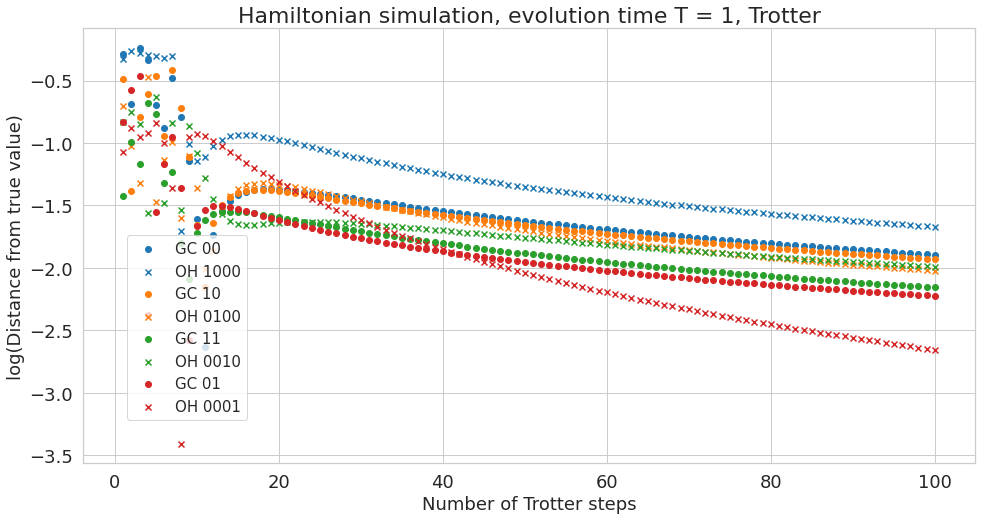

In [25]:
sns.set(rc={'figure.figsize':(16,8)})
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style('whitegrid')

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
colour_idx = 0

for state_gc, state_oh in zip(results_dict_gc.keys(), results_dict_oh.keys()):
    gc_log_results = np.log10(np.abs(results_dict_gc[state_gc] - true_results_gc[state_gc]))
    oh_log_results = np.log10(np.abs(results_dict_oh[state_oh] - true_results_oh[state_oh]))
    
    plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=gc_log_results, label=f"GC {state_gc}", color=colours[colour_idx])
    plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=oh_log_results, label=f"OH {state_oh}", marker='x', color=colours[colour_idx])
    plt.xlabel("Number of Trotter steps", fontsize=18)
    plt.ylabel("log(Distance from true value)", fontsize=18)
    plt.legend(fontsize=15, loc=(0.05, 0.1))
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(f"Hamiltonian simulation, evolution time T = {T}, Trotter", fontsize=22)
    colour_idx += 1
    
#plt.savefig(f"evolution.pdf")
plt.show()

## Circuit properties

Let's also analyze the properties of the evolution circuits; how do the gate counts and depths compare?

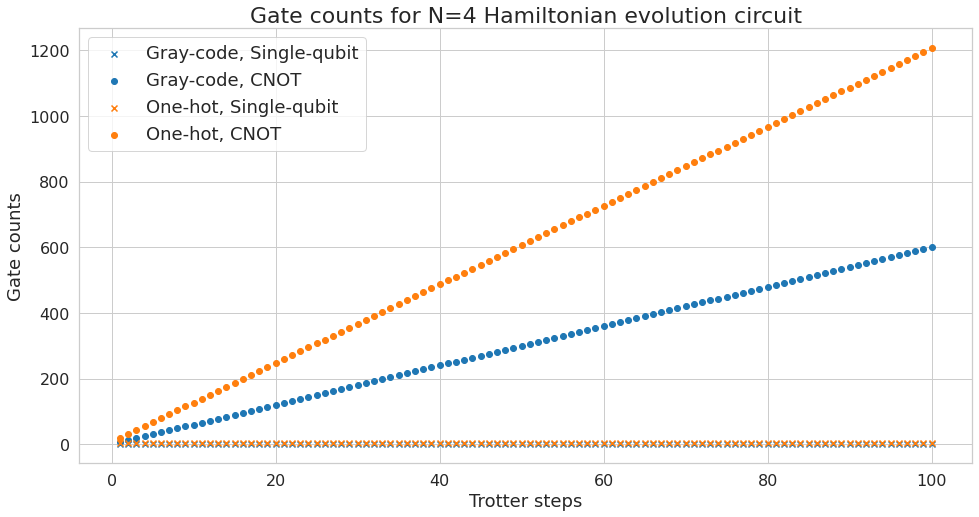

In [26]:
sns.set(rc={'figure.figsize':(16,8)})
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style('whitegrid')


plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=gate_counts_gc[:,0], label='Gray-code, Single-qubit', marker='x', color='tab:blue')
plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=gate_counts_gc[:,1], label='Gray-code, CNOT', marker='o', color='tab:blue')
plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=gate_counts_oh[:,0], label='One-hot, Single-qubit', marker='x', color='tab:orange')
plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=gate_counts_oh[:,1], label='One-hot, CNOT', marker='o', color='tab:orange')
plt.legend(fontsize = 18)
plt.xlabel("Trotter steps", fontsize=18)
plt.ylabel("Gate counts", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Gate counts for N=4 Hamiltonian evolution circuit", fontsize=22);
#plt.savefig("paper-figures/gate_counts_trotter.pdf")

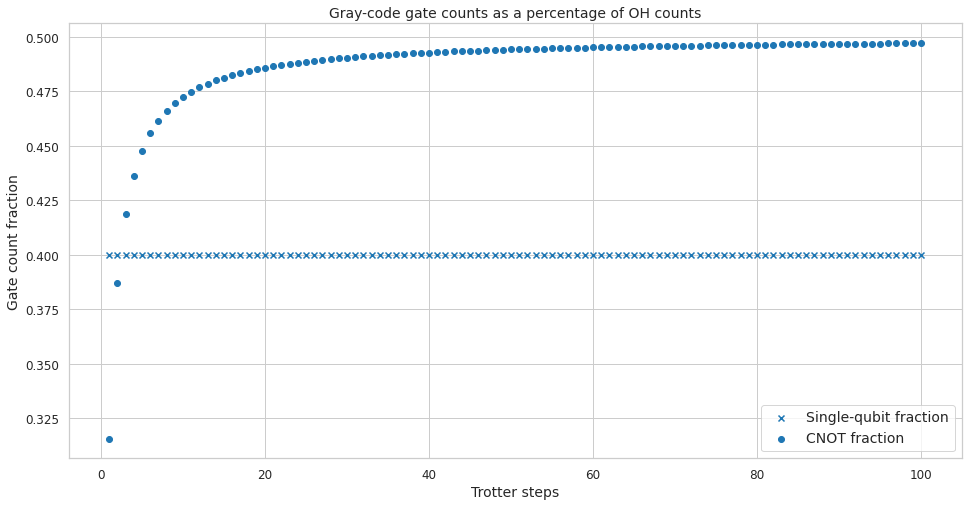

In [27]:
plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=gate_counts_gc[:,0]/gate_counts_oh[:, 0], label='Single-qubit fraction', marker='x', color='tab:blue')
plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=gate_counts_gc[:,1]/gate_counts_oh[:, 1], label='CNOT fraction', marker='o', color='tab:blue')
plt.legend(fontsize = 14)
plt.xlabel("Trotter steps", fontsize=14)
plt.ylabel("Gate count fraction", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Gray-code gate counts as a percentage of OH counts", fontsize=14);

Text(0.5, 1.0, 'Circuit depth for N=4 Hamiltonian evolution circuit')

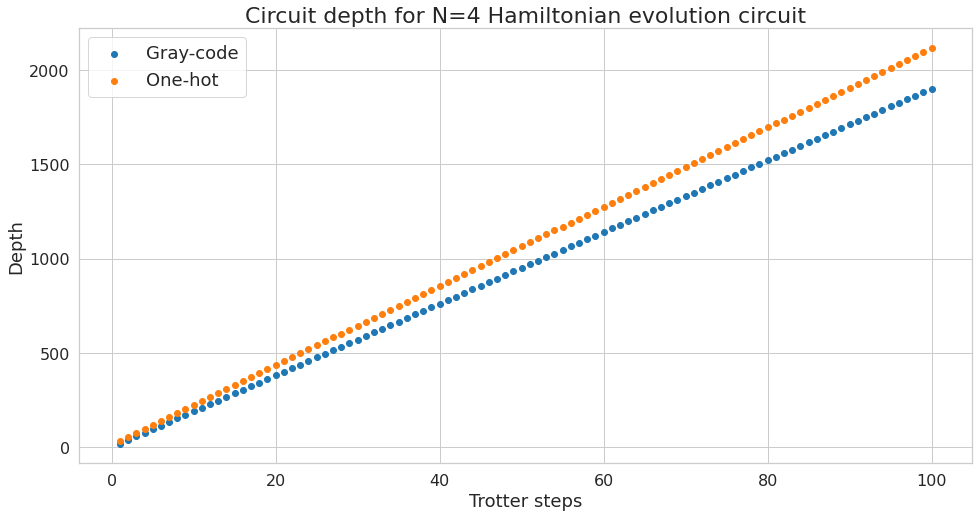

In [28]:
plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=gate_counts_gc[:, 2], label='Gray-code', color='tab:blue')
plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=gate_counts_oh[:, 2], label='One-hot', color='tab:orange')
plt.xlabel("Trotter steps", fontsize=18)
plt.ylabel("Depth", fontsize=18)
plt.legend(fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Circuit depth for N=4 Hamiltonian evolution circuit", fontsize=22)
#plt.savefig("paper-figures/circuit_depth_trotter.pdf");

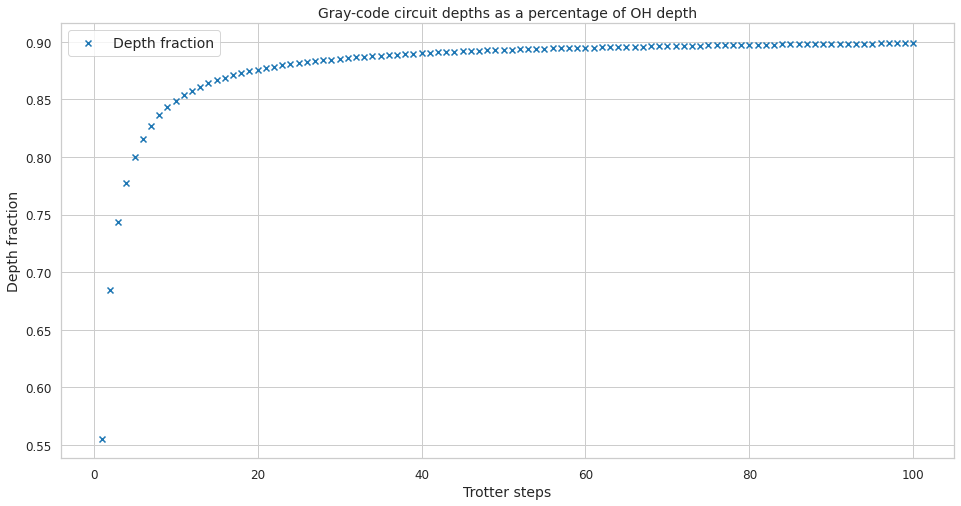

In [29]:
plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=gate_counts_gc[:,2]/gate_counts_oh[:, 2], label='Depth fraction', marker='x', color='tab:blue')
plt.legend(fontsize = 14)
plt.xlabel("Trotter steps", fontsize=14)
plt.ylabel("Depth fraction", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Gray-code circuit depths as a percentage of OH depth", fontsize=14);